In [18]:
import torchvision.transforms as transforms
import torchvision.models as models
import cv2 as cv2
import torch_dct as dct
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from torchattacks import FGSM, CW, PGD
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
def read_img(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transforms.ToTensor()(img)
    print(img_tensor.size())
    return img_tensor

In [3]:
def show_tensor(tensor,width=200,height=200):
    tensor_img = transforms.ToPILImage()(tensor)
    display(tensor_img.resize((width,height)))

torch.Size([3, 3647, 3647])


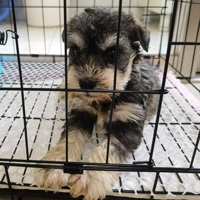

In [4]:
fn = 'imgs/lion.jpg'
img_tensor = read_img(fn)
show_tensor(img_tensor)

In [5]:
def dct_tensor(tensor):
    img_dct = dct.dct(tensor)
    show_tensor(img_dct)

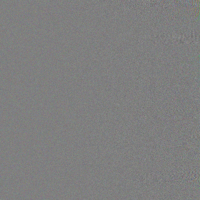

In [6]:
img_tensor_dct = dct_tensor(img_tensor)

In [7]:
rn50 = models.resnet50(weights="IMAGENET1K_V1")
rn50 = rn50.eval()

In [8]:
model = nn.Sequential(transforms.Resize([224,224],antialias=True),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      rn50)
model = model.cuda()

In [9]:
def predict_1_img(img_tensor,model):
    res = model(img_tensor.unsqueeze(0).cuda())
    label = res[0].argmax().item()
    prob = F.softmax(res,dim=1)[0].max().item()
    return label, prob

In [10]:
print(predict_1_img(img_tensor,model))

(196, 0.9758331179618835)


In [17]:
def attack_1_img(model,img_tensor,label,atk_name,**kwargs):
    atk = eval(atk_name)(model,kwargs)
    adv_img_tensor = atk(img_tensor.unsqueeze(0).cuda(),labels = torch.Tensor([label]).cuda().type(torch.LongTensor))
    print(predict_1_img(adv_img_tensor[0],model))
    show_tensor(adv_img_tensor[0])
    return adv_img_tensor

In [ ]:
adv_imgs = attack_1_img(model,img_tensor,196,'CW',c=1, kappa=0, steps=50, lr=0.01)

(185, 0.2381698191165924)


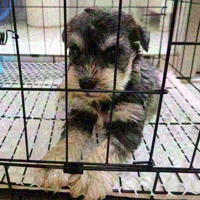

In [26]:
adv_imgs = attack_1_img(model,img_tensor,196,'FGSM')

In [13]:
model2 = nn.Sequential(transforms.Resize([299,299],antialias=True),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      models.inception_v3(weights='IMAGENET1K_V1'))

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/zhanghanxiu/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:45<00:00, 2.38MB/s] 
